In [1]:
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score
import pandas as pd
import numpy as np
import statsmodels.api as sm
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.stats.diagnostic import het_arch
import itertools
from statsmodels.tsa.stattools import arma_order_select_ic
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [2]:
from google.colab import files
uploaded = files.upload()

Saving taux_chomage.xlsx to taux_chomage.xlsx


In [3]:
data = pd.read_excel('taux_chomage.xlsx')
data.head()

,Période,Taux_chomage
0,1975-T1,2.2
1,1975-T2,2.5
2,1975-T3,2.7
3,1975-T4,2.8
4,1976-T1,2.8


In [4]:
data['Taux_chomage'].describe()

count    188.000000
mean       7.218085
std        2.046986
min        2.200000
25%        6.200000
50%        7.500000
75%        8.700000
max       10.700000
Name: Taux_chomage, dtype: float64

In [5]:
# Renaming columns for clarity
data.columns = ['Période', 'Taux_chomage']

# Removing any non-numeric values in the 'Unemployment_Rate' column
data['Taux_chomage'] = pd.to_numeric(data['Taux_chomage'], errors='coerce')

# Dropping rows with missing values
data.dropna(inplace=True)

# Displaying the cleaned data
data.head(), data.tail()

(   Période  Taux_chomage
 0  1975-T1           2.2
 1  1975-T2           2.5
 2  1975-T3           2.7
 3  1975-T4           2.8
 4  1976-T1           2.8,
      Période  Taux_chomage
 183  2020-T4           8.0
 184  2021-T1           8.3
 185  2021-T2           7.8
 186  2021-T3           7.6
 187  2021-T4           7.4)

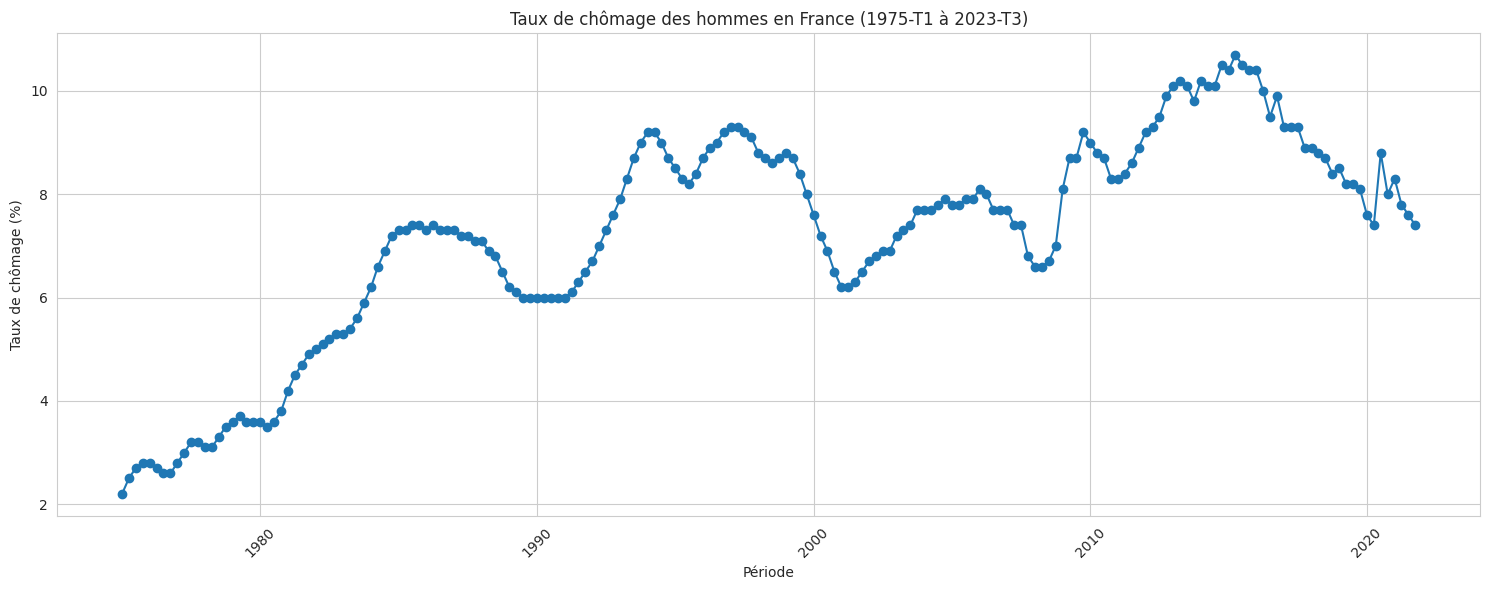

In [6]:
# Converting 'Period' from PeriodIndex to datetime for plotting

sns.set_style("whitegrid")

def convert_period_to_date(period):
    if isinstance(period, str):
        year, quarter = period.split('-')
        quarter_month_map = {'T1': '01-01', 'T2': '04-01', 'T3': '07-01', 'T4': '10-01'}
        return f"{year}-{quarter_month_map[quarter]}"
    else:
        return period
data['Période'] = data['Période'].apply(convert_period_to_date)
data['Période'] = pd.to_datetime(data['Période'])


plt.figure(figsize=(15, 6))
plt.plot(data['Période'], data['Taux_chomage'], marker='o', linestyle='-')
plt.title('Taux de chômage des hommes en France (1975-T1 à 2023-T3)')
plt.xlabel('Période')
plt.ylabel('Taux de chômage (%)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [7]:
# Suppression des éventuelles lignes avec des valeurs manquantes
data.dropna(subset=['Taux_chomage'], inplace=True)

# Calcul de l'évolution logarithmique du taux de chômage
data['Evolution_Log'] = np.log(data['Taux_chomage']).diff()
data['Log_Evolution'] = np.log(data['Taux_chomage'])

data.head(), data.tail()

(     Période  Taux_chomage  Evolution_Log  Log_Evolution
 0 1975-01-01           2.2            NaN       0.788457
 1 1975-04-01           2.5       0.127833       0.916291
 2 1975-07-01           2.7       0.076961       0.993252
 3 1975-10-01           2.8       0.036368       1.029619
 4 1976-01-01           2.8       0.000000       1.029619,
        Période  Taux_chomage  Evolution_Log  Log_Evolution
 183 2020-10-01           8.0      -0.095310       2.079442
 184 2021-01-01           8.3       0.036814       2.116256
 185 2021-04-01           7.8      -0.062132       2.054124
 186 2021-07-01           7.6      -0.025975       2.028148
 187 2021-10-01           7.4      -0.026668       2.001480)

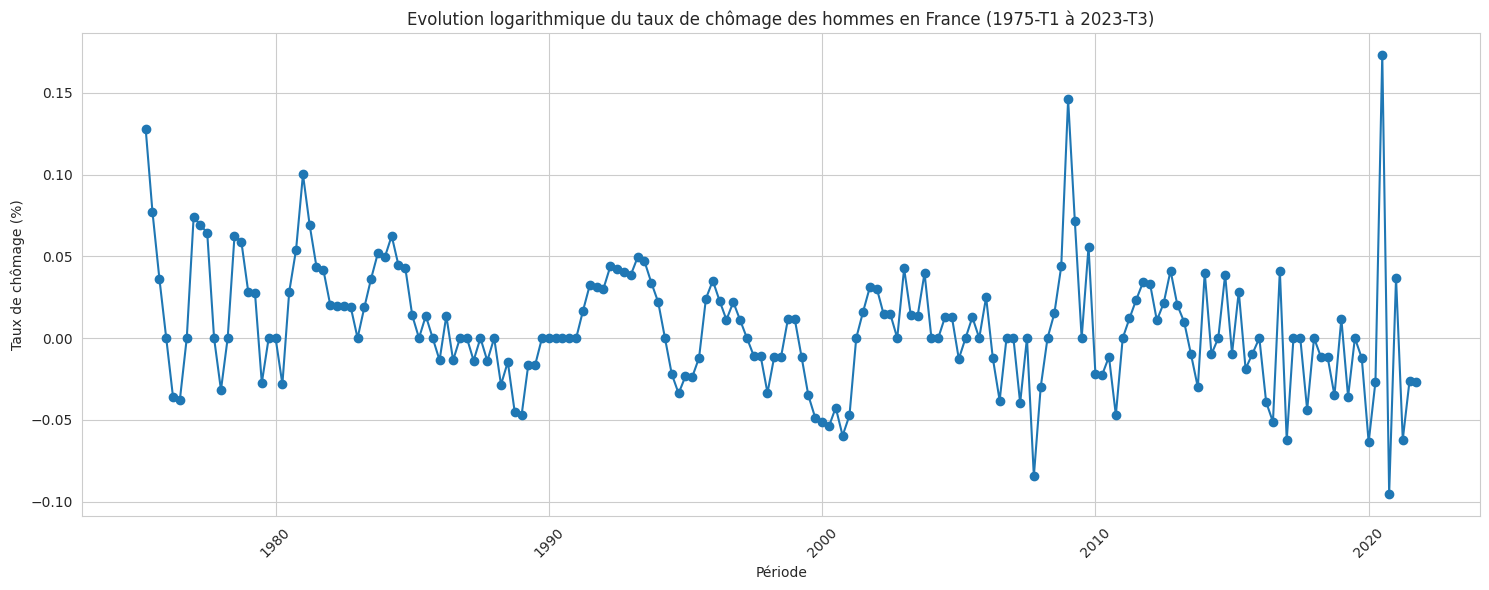

In [8]:
# Converting 'Period' from PeriodIndex to datetime for plotting

sns.set_style("whitegrid")

def convert_period_to_date(period):
    if isinstance(period, str):
        year, quarter = period.split('-')
        quarter_month_map = {'T1': '01-01', 'T2': '04-01', 'T3': '07-01', 'T4': '10-01'}
        return f"{year}-{quarter_month_map[quarter]}"
    else:
        return period

data['Période'] = data['Période'].apply(convert_period_to_date)
data['Période'] = pd.to_datetime(data['Période'])

plt.figure(figsize=(15, 6))
plt.plot(data['Période'], data['Evolution_Log'], marker='o', linestyle='-')
plt.title('Evolution logarithmique du taux de chômage des hommes en France (1975-T1 à 2023-T3)')
plt.xlabel('Période')
plt.ylabel('Taux de chômage (%)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [9]:
# Test de Dickey-Fuller augmenté pour vérifier la stationnarité
result = adfuller(data['Taux_chomage'])

df_test_statistic = result[0]
df_p_value = result[1]
df_critical_values = result[4]

df_test_statistic, df_p_value, df_critical_values

(-2.433979306951529,
 0.132374725910114,
 {'1%': -3.468952197801766,
  '5%': -2.878495056473015,
  '10%': -2.57580913601947})

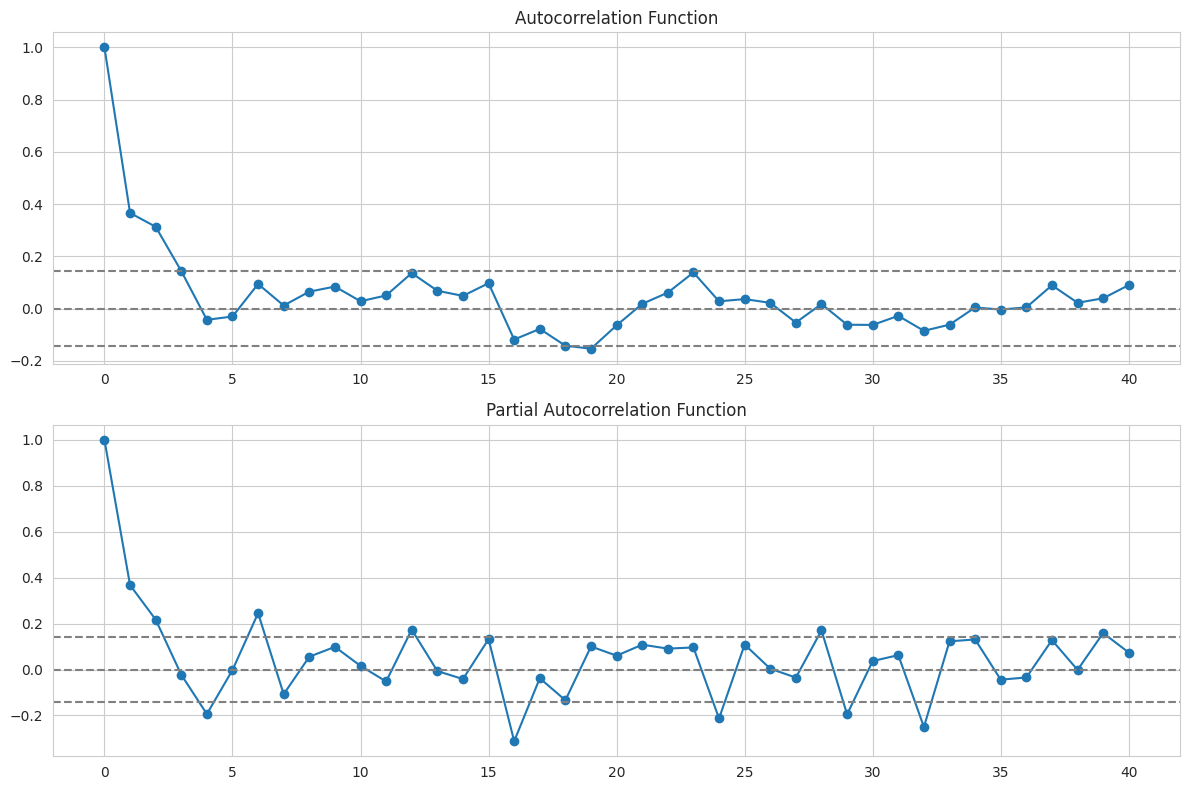

{'ADF Statistic': -3.172894817497877,
 'p-value': 0.021608226734428016,
 'Used lag': 15,
 'Number of observations': 171,
 'Critical values': {'1%': -3.4691814633722453,
  '5%': -2.878595143532943,
  '10%': -2.5758625549741803}}

In [10]:
# Test de stationnarité (Test de Dickey-Fuller augmenté)
adf_test = adfuller(data['Evolution_Log'].dropna())

# l'ACF et PACF pour la série de l'évolution logarithmique
lags = 40  # Nombre de décalages à considérer pour ACF et PACF
acf_values = acf(data['Evolution_Log'].dropna(), nlags=lags)
pacf_values = pacf(data['Evolution_Log'].dropna(), nlags=lags, method='ols')


fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))

ax1.plot(acf_values, marker='o')
ax1.axhline(y=0, linestyle='--', color='gray')
ax1.axhline(y=-1.96/np.sqrt(len(data['Evolution_Log'].dropna())), linestyle='--', color='gray')
ax1.axhline(y=1.96/np.sqrt(len(data['Evolution_Log'].dropna())), linestyle='--', color='gray')
ax1.set_title('Autocorrelation Function')

ax2.plot(pacf_values, marker='o')
ax2.axhline(y=0, linestyle='--', color='gray')
ax2.axhline(y=-1.96/np.sqrt(len(data['Evolution_Log'].dropna())), linestyle='--', color='gray')
ax2.axhline(y=1.96/np.sqrt(len(data['Evolution_Log'].dropna())), linestyle='--', color='gray')
ax2.set_title('Partial Autocorrelation Function')

plt.tight_layout()
plt.show()

# Résultats du test ADF
adf_test_result = {
    'ADF Statistic': adf_test[0],
    'p-value': adf_test[1],
    'Used lag': adf_test[2],
    'Number of observations': adf_test[3],
    'Critical values': adf_test[4]
}

adf_test_result

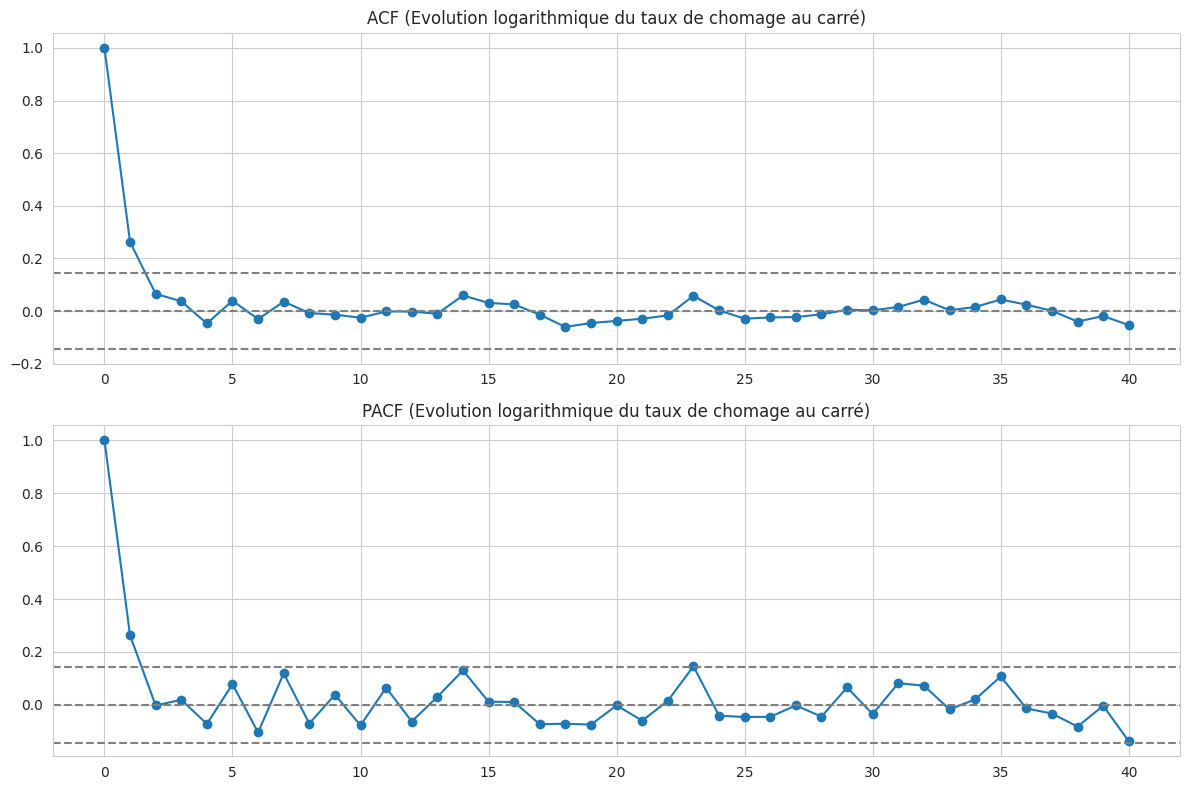

In [11]:
# Calcul de l'évolution logarithmique du taux de chômage au carré
data['Evolution_Log_Squared'] = data['Evolution_Log']**2

# l'ACF et PACF pour la série de l'évolution logarithmique du taux de chômage au carré
acf_values_squared = acf(data['Evolution_Log_Squared'].dropna(), nlags=lags)
pacf_values_squared = pacf(data['Evolution_Log_Squared'].dropna(), nlags=lags, method='ols')

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))

ax1.plot(acf_values_squared, marker='o')
ax1.axhline(y=0, linestyle='--', color='gray')
ax1.axhline(y=-1.96/np.sqrt(len(data['Evolution_Log_Squared'].dropna())), linestyle='--', color='gray')
ax1.axhline(y=1.96/np.sqrt(len(data['Evolution_Log_Squared'].dropna())), linestyle='--', color='gray')
ax1.set_title('ACF (Evolution logarithmique du taux de chomage au carré)')

ax2.plot(pacf_values_squared, marker='o')
ax2.axhline(y=0, linestyle='--', color='gray')
ax2.axhline(y=-1.96/np.sqrt(len(data['Evolution_Log_Squared'].dropna())), linestyle='--', color='gray')
ax2.axhline(y=1.96/np.sqrt(len(data['Evolution_Log_Squared'].dropna())), linestyle='--', color='gray')
ax2.set_title('PACF (Evolution logarithmique du taux de chomage au carré)')

plt.tight_layout()
plt.show()


In [12]:
# Test pour détecter l'effet ARCH dans la série différenciée logarithmiquement
arch_test_results = het_arch(data['Evolution_Log'].dropna())
arch_test_results = pd.Series(arch_test_results[0:3], index=['Test Statistic', 'p-value', 'Lags'])

arch_test_results

Test Statistic    17.627135
p-value            0.061589
Lags               1.836012
dtype: float64

In [13]:
# Fitting SARIMA model
sarima_model = ARIMA(data['Evolution_Log'], order=(1, 0, 1), seasonal_order=(2, 0, 3, 4))
sarima_results = sarima_model.fit()
residual = sarima_results.resid
# AIC and BIC for SARIMA model
sarima_aic, sarima_bic = sarima_results.aic, sarima_results.bic

residual.dropna(inplace=True)

sarima_aic, sarima_bic, residual, sarima_results.summary()

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(-733.5062265183929,
 -704.3782488529233,
 1      0.121295
 2      0.020436
 3     -0.011806
 4     -0.029400
 5     -0.035578
          ...   
 183   -0.126400
 184    0.017801
 185   -0.064690
 186    0.019703
 187   -0.032219
 Length: 187, dtype: float64,
 <class 'statsmodels.iolib.summary.Summary'>
 """
                                         SARIMAX Results                                        
 Dep. Variable:                           Evolution_Log   No. Observations:                  188
 Model:             ARIMA(1, 0, 1)x(2, 0, [1, 2, 3], 4)   Log Likelihood                 375.753
 Date:                                 Sun, 10 Dec 2023   AIC                           -733.506
 Time:                                         20:57:02   BIC                           -704.378
 Sample:                                              0   HQIC                          -721.705
                                                  - 188                                         
 Covariance 

In [14]:
n_periods = 6
forecast_result = sarima_results.get_forecast(steps=n_periods)

# Accédez aux valeurs prévues et aux intervalles de confiance
forecast_value = forecast_result.predicted_mean
confidence_intervals = forecast_result.conf_int()

print(forecast_value)
print(confidence_intervals)

188   -0.023554
189   -0.009429
190    0.023853
191   -0.005986
192   -0.011663
193   -0.008820
Name: predicted_mean, dtype: float64
     lower Evolution_Log  upper Evolution_Log
188            -0.086813             0.039704
189            -0.076646             0.057788
190            -0.045438             0.093145
191            -0.076388             0.064417
192            -0.082068             0.058742
193            -0.079302             0.061663


In [15]:
# Calculating the last observed value of the logarithmic unemployment rate
last_value = data['Log_Evolution'].iloc[-1]

cumulative_forecast_logs = last_value + forecast_value.cumsum()

# Converting the cumulative log forecasts back to the original scale (exponentiating)
forecasted_unemployment_rate = np.exp(cumulative_forecast_logs)

# Displaying the forecasted unemployment rate
forecasted_unemployment_rate

# Calculer les intervalles de confiance pour le taux de chômage
lower_bounds = confidence_intervals.iloc[:, 0]  # Bornes inférieures
upper_bounds = confidence_intervals.iloc[:, 1]  # Bornes supérieures

#Appliquer la transformation exponentielle aux intervalles de confiance
conf_int_lower = np.exp(last_value + lower_bounds)
conf_int_upper = np.exp(last_value + upper_bounds)

forecast_with_conf_int = pd.DataFrame({
    #'Forecasted Unemployment Rate': forecasted_unemployment_rate,
    'Lower Bound CI': conf_int_lower,
    'Upper Bound CI': conf_int_upper
})

# Afficher les résultats
print(forecast_with_conf_int), print(forecasted_unemployment_rate)

     Lower Bound CI  Upper Bound CI
188        6.784679        7.699724
189        6.854009        7.840231
190        7.071283        8.122392
191        6.855776        7.892371
192        6.816948        7.847713
193        6.835830        7.870665
188    7.227735
189    7.159905
190    7.332745
191    7.288983
192    7.204465
193    7.141203
Name: predicted_mean, dtype: float64


(None, None)

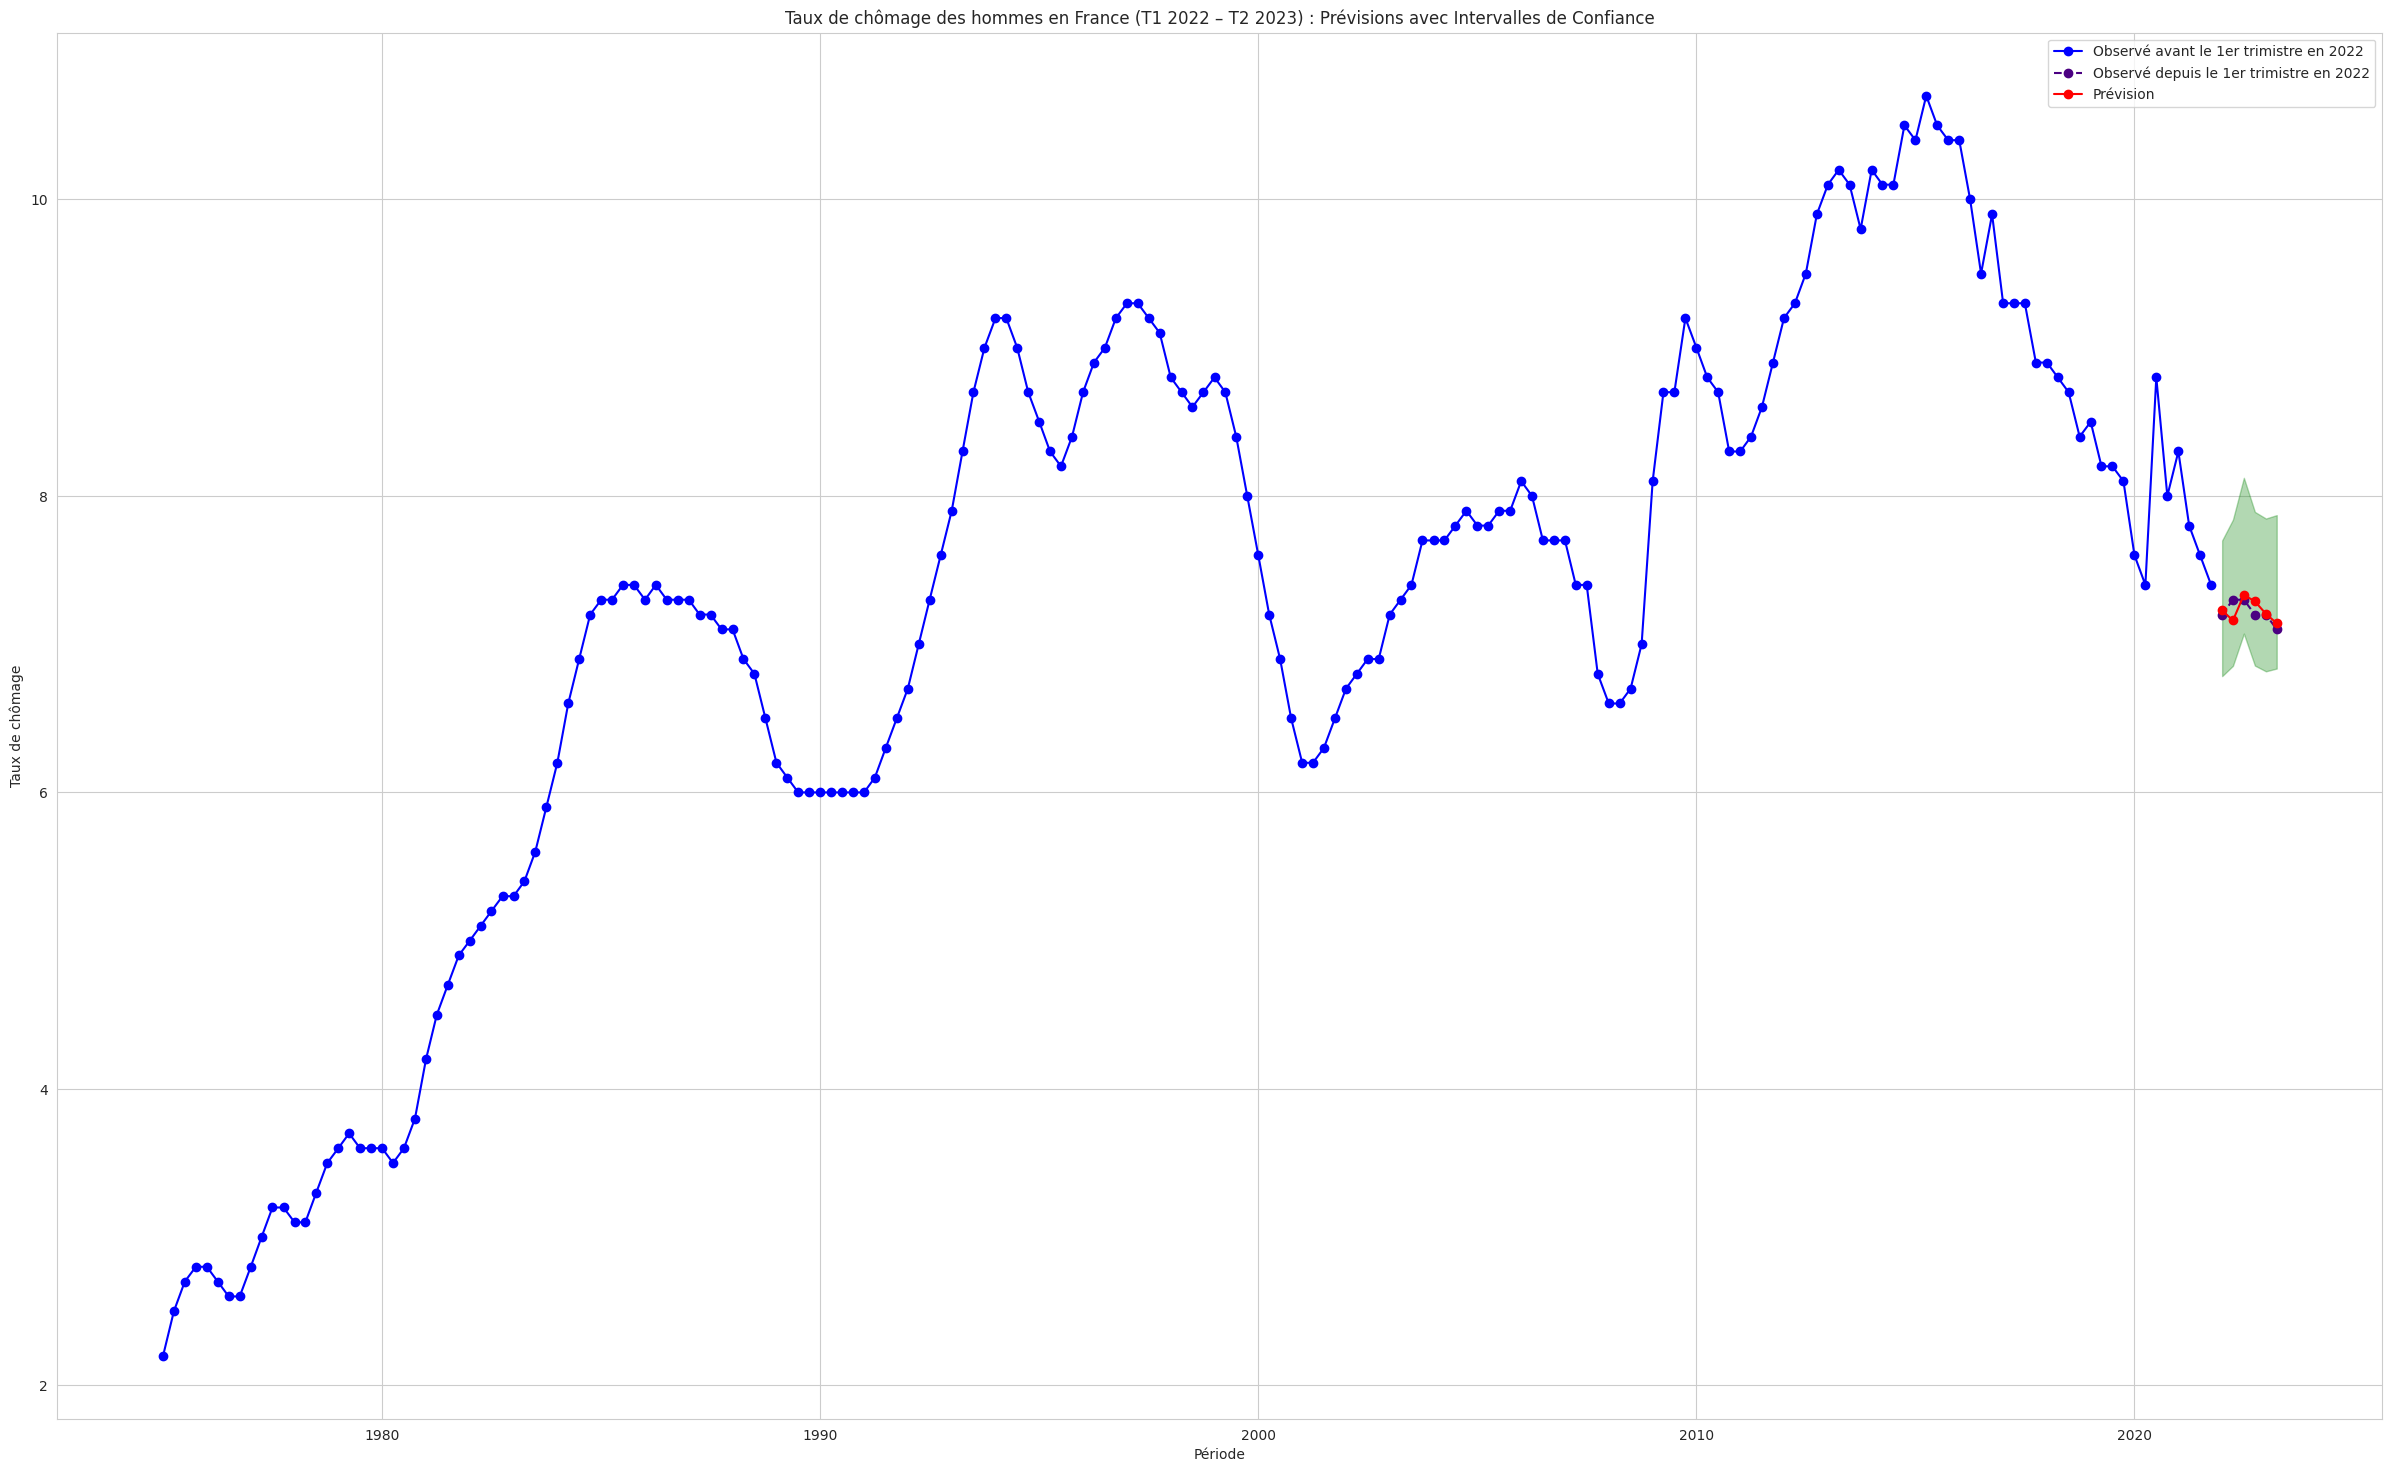

In [16]:
# Créer une série de dates pour la période de prévision
forecast_periods = ['2022-T1', '2022-T2', '2022-T3', '2022-T4', '2023-T1', '2023-T2']  # Exemple de périodes
forecast_dates = pd.to_datetime([convert_period_to_date(period) for period in forecast_periods])

forecasted_unemployment_rate.index = forecast_dates  # Utiliser la série de dates créées précédemment
forecast_with_conf_int.index = forecast_dates

# Nouvelles données observées
new_observed_values = [7.2, 7.3, 7.3, 7.2, 7.2 ,7.1]
new_observed_dates = pd.to_datetime([convert_period_to_date(period) for period in forecast_periods[:len(new_observed_values)]])
new_observed_series = pd.Series(new_observed_values, index=new_observed_dates)

plt.figure(figsize=(30, 18))
plt.plot(data['Période'], data['Taux_chomage'], label='Observé avant le 1er trimistre en 2022', color='blue',  marker='o')  # Remplacer 'Evolution_Log' par la série appropriée
plt.plot(new_observed_series.index, new_observed_series, label='Observé depuis le 1er trimistre en 2022', color='indigo', marker='o', linestyle='dashed')
plt.plot(forecasted_unemployment_rate.index, forecasted_unemployment_rate, label='Prévision', color='red',  marker='o')

# Ajout des intervalles de confiance
plt.fill_between(forecast_with_conf_int.index,
                 forecast_with_conf_int.iloc[:, 0],
                 forecast_with_conf_int.iloc[:, 1],
                 color='green', alpha=0.3)

plt.title('Taux de chômage des hommes en France (T1 2022 – T2 2023) : Prévisions avec Intervalles de Confiance')
plt.xlabel("Période")
plt.ylabel("Taux de chômage")
plt.legend()
plt.show()

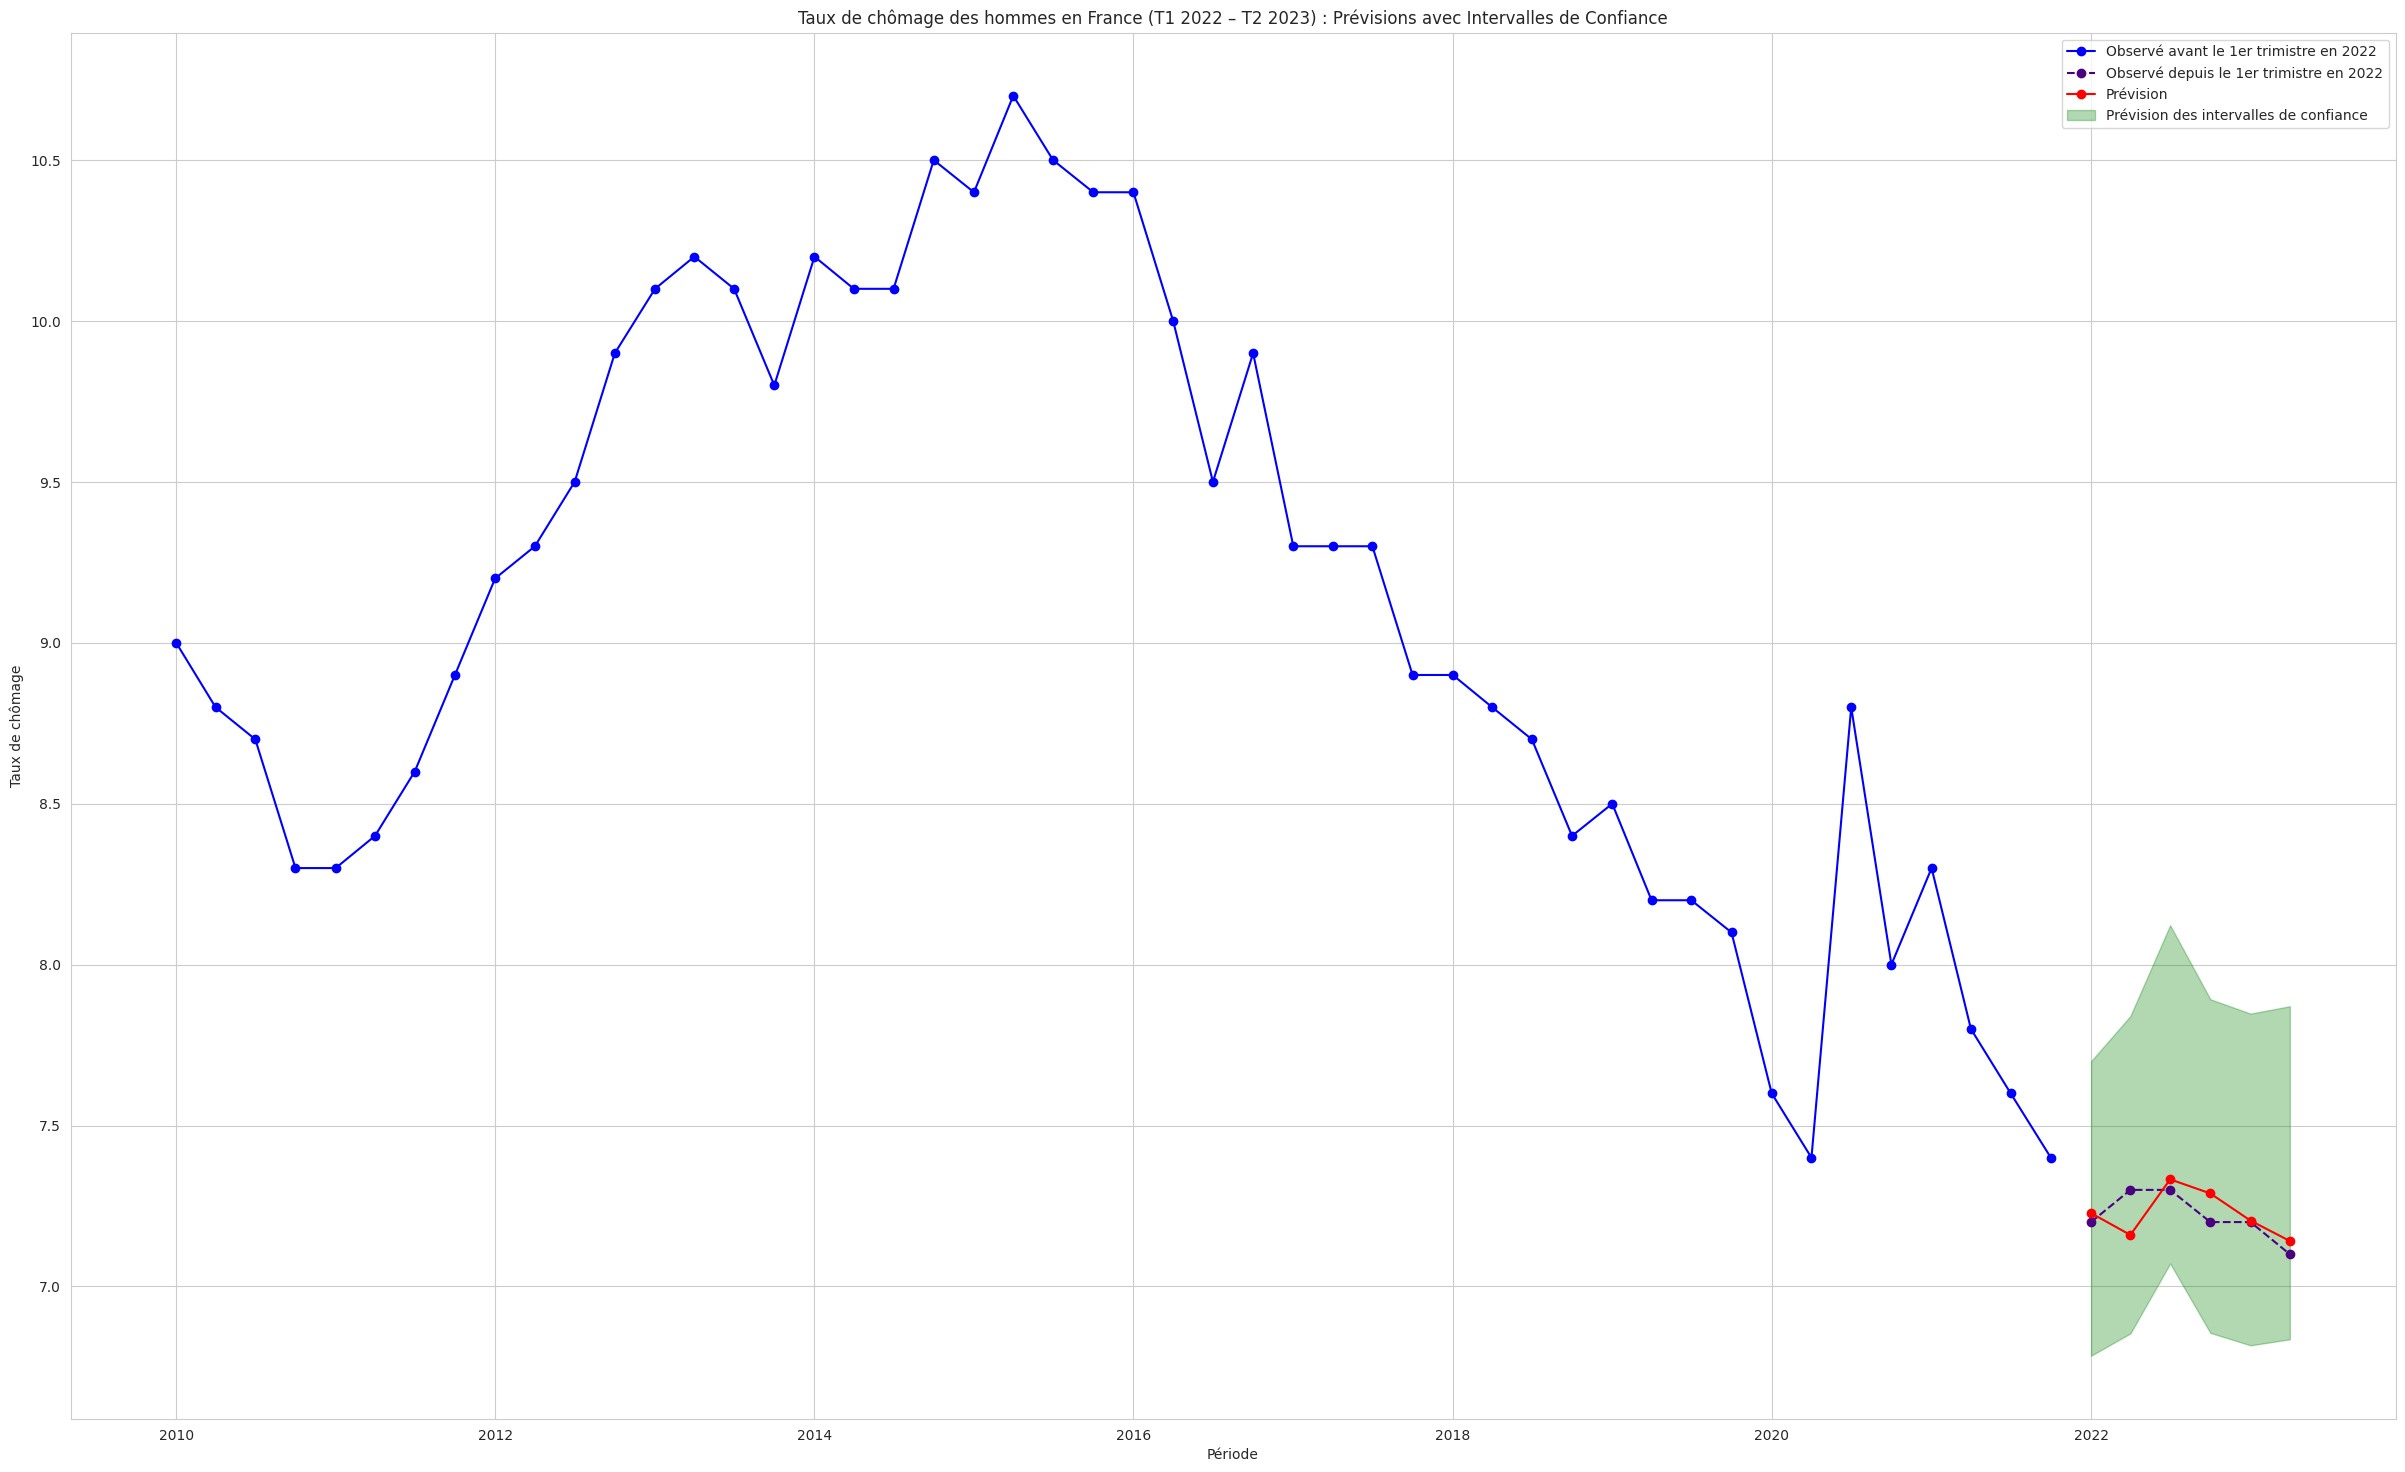

In [17]:
# Filtrer les données pour ne conserver que celles après 2016
data_filtered = data[pd.to_datetime(data['Période']) >= pd.Timestamp('2010-01-01')]
# Nouvelles données observées
new_observed_values = [7.2, 7.3, 7.3, 7.2, 7.2 ,7.1]
new_observed_dates = pd.to_datetime([convert_period_to_date(period) for period in forecast_periods[:len(new_observed_values)]])
new_observed_series = pd.Series(new_observed_values, index=new_observed_dates)

plt.figure(figsize=(30, 18))
plt.plot(data_filtered['Période'], data_filtered['Taux_chomage'], label='Observé avant le 1er trimistre en 2022', color='blue',  marker='o')  # Remplacer 'Evolution_Log' par la série appropriée
plt.plot(new_observed_series.index, new_observed_series, label='Observé depuis le 1er trimistre en 2022', color='indigo', marker='o', linestyle='dashed')
plt.plot(forecasted_unemployment_rate.index, forecasted_unemployment_rate, label='Prévision', color='red',  marker='o')

# Ajout des intervalles de confiance
plt.fill_between(forecast_with_conf_int.index,
                 forecast_with_conf_int.iloc[:, 0],
                 forecast_with_conf_int.iloc[:, 1],
                 label='Prévision des intervalles de confiance', color='green', alpha=0.3)

plt.title('Taux de chômage des hommes en France (T1 2022 – T2 2023) : Prévisions avec Intervalles de Confiance')
plt.xlabel("Période")
plt.ylabel("Taux de chômage")
plt.legend()
plt.show()

In [18]:
# Fonction pour la validation croisée personnalisée
def custom_cross_validation(data, periods, order, seasonal_order):
    errors = []
    for i in range(1, len(periods)):
        train = data[:i]
        test = data[i:i+1]

        forecast = forecasted_unemployment_rate

        error = test[0] - forecast[0]
        errors.append(error)

    return errors

# Définition de l'ordre et de l'ordre saisonnier du modèle SARIMA
order = (1, 0, 1)
seasonal_order = (2, 0, 3, 12)

# Utilisation de la fonction de validation croisée personnalisée
errors = custom_cross_validation(new_observed_values, forecast_periods, order, seasonal_order)

# Analyse des erreurs de prévision
mean_error = np.mean(errors)
std_error = np.std(errors)

print(f"Moyenne des erreurs : {mean_error}")
print(f"Écart-type des erreurs : {std_error}")

Moyenne des erreurs : -0.007734805624450658
Écart-type des erreurs : 0.07483314773547885
